In [1]:
#Include important files
include("TestBestPlannerHeader.jl")


get_grid_resolution (generic function with 1 method)

In [2]:
#Construct the tuning params and the path problem
tuningI = TuningParams([0],  # q_coeff::Vector{Int64}
                       [0.0],# softConstrWeights::Vector{Float64}
                        0.0,  # numericVelWeight::Float64       
                        0.0,  # obstacleWeight::Float64    
                        0.0,  # derivativeWeight::Float64     
                        1e-8, # precision::Float64              
                        20,   # iterations::Int64      
                        0.01, # timeStep::Float64     
                        1.0,  # timeStart::Float64    
                        0.7,  # aggressParam:Float64        
                        0.1,  # timeIncrease::Float64            
                        2.0,  # max_vel::Float64           
                        0.65, # max_accel::Float64        
                        10.0, # max_jerk::Float64             
                        10);  # numberOfRandomRestarts::Int64   
problem = PathProblem( [0.0 0.0 0.0;        # x
                        0.0 0.0 0.0;        # y
                        0.0 0.0 0.0],       # z  #start_config::Array{Float64,2}   
                       [0.0 0.0 0.0;        # x
                        0.0 0.0 0.0;        # y
                        0.0 0.0 0.0],       # z #end_config::Array{Float64,2}      
                       [false;false;false], # soft_constr::Vector{Bool}     
                        true,               # DijkstraNotFMT::Bool          
                        zeros(0,2),         # PconstrFixed::Array{Float64,2}  
    #TODO: actually create a constructor function to construct the constr* and time index vectors
                        zeros(0,2),         # PconstrFree::Array{Float64,2}       
                        [0;0;0;1;1;1],      # PtimeIndex::Vector{Int64}       
                        [0;1;2;0;1;2],      # PconstraintOrders::Vector{Int64}
                        zeros(0,2),         # PconstraintSoft::Array{Float64,2}    
                        false,              # isDim3::Bool                  
                        0,                  # dof::{Int64}                   
                        zeros(0,0,1),       # costmap::Array{Int8,3}         
                        10.0,               # grid_extent::Float64  
                        0.1,                # grid_resolution::Float64
                        0,                  # Pgrid_elementNum::Int64 
                        0)                  # Pdegree::Int64 

PathProblem([0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0],[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0],Bool[false,false,false],true,,,[0,0,0,1,1,1],[0,1,2,0,1,2],,false,0,,10.0,0.1,0)

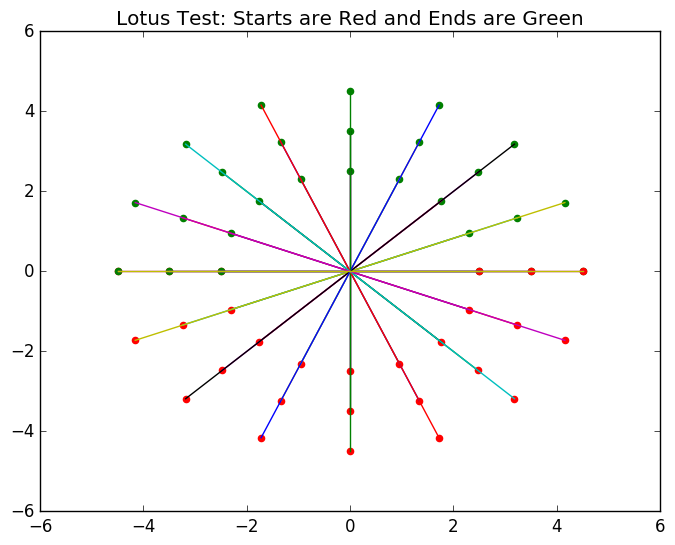

PyObject <matplotlib.text.Text object at 0x00000000263AFA58>

In [3]:
#Do the lotus test
lotusTest(  5.0,       # initial_distance::Float64, 
            tuningI,   # tuning::TuningParams, 
            7,         # number2Rotate::Int64,
            2.0,       # distanceChange::Float64, 
            1,         # figureNum::Int64)
            problem)   # pathProb::PathProblem

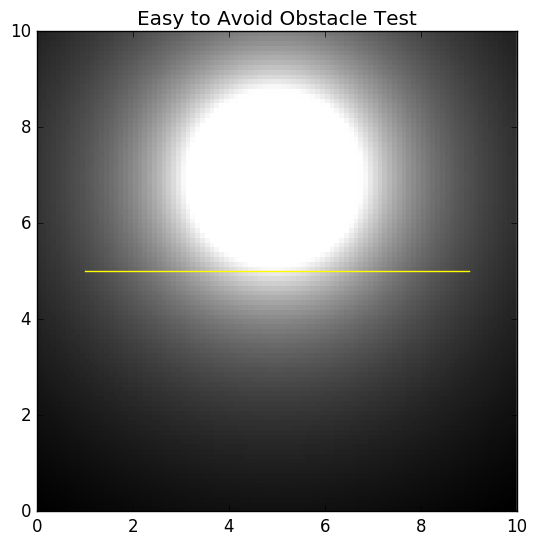

PyObject <matplotlib.text.Text object at 0x0000000026B0DD68>

In [10]:
#Easy Bump Test
easyAvoidBumpTest(  tuningI,# bumpTuning::TuningParams, 
                    problem,# pathProblem::PathProblem, 
                    5000,   # bumpSize::Int64)
                    2,      # figNum::Int64 = 1
                    7.0)    # bumpYLoc::Float64 default is 5.0

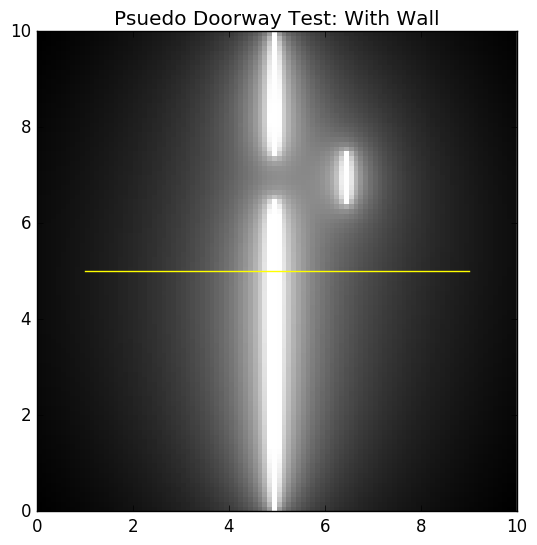

PyObject <matplotlib.text.Text object at 0x0000000026CD0E48>

In [11]:
#Doorway Test
#TODO: make params more understandable/consistent with user expectations
#TODO: Add input validation to this test
doorwayTest(tuningI,#wallTuning::TuningParams, 
            problem,#pathProblem::PathProblem, 
            30,     #wallSize::Int64, 
            3,      #figNum::Int64, 
            7.0,    #doorYLoc::Float64, 
            10.0,   #doorWidth::Float64)
            true,   #wallBehindDoor::Bool = false, 
            1.5)    #wallDistance::Float64 = 2.0

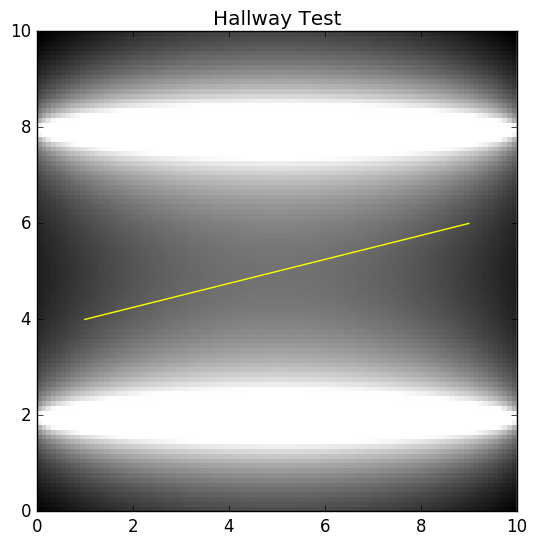

PyObject <matplotlib.text.Text object at 0x0000000026E888D0>

In [12]:
#Hallway Test
#TODO: Add input validation to this test
hallwayTest(tuningI,#hallTuning::TuningParams, 
            problem,#pathProblem::PathProblem, 
            35,     #wallSize::Int64, 
            4)      #figNum::Int64)

In [13]:
#Random Tuning/Problem Variation Test
#Descritption - the tuning parameters will be varied through a range of values for a constant path problem. Only
# one thing changes
#Requires heavy user input
#This is the Skeleton of the process and a specific variable should be used
#Set bottom value
#Set top value
#Create range between those values
#Loop through the range 
#Set the current value to its appropriate spot in the object
#Run the planner
#Plot
#End Loop

In [14]:
#Random Ros Bag Test
#Description - read in a ros bag's costmap and path for that costmap
#Inputs
# rosbag
#Expected Outcomes - a plot 

#Pseudo code since I do not know how to do this in Julia yet
#Read in rosbag
#Record a coinciding costmap and global path
#Translate to odom frame
#Pick local goals
#Start timer
#Run path planner
#If unsuccessful choose a different goal until out of goals or successful
#End timer
#Print time
#Plot planned path over the costmap

In [15]:
#Psuedo Code
#Changeable value


#CONSTRUCT the constraint Vectors given initial, end, dof and soft constraint vectors, dicjkstras
    #create the order and timeIndex 
    #Possibly if dijkstras Create a normalized direction vector
    #Create time vector assuming 1 second for the final conditions and zero for the initial conditions
    #Calculate the degree of the desired poly <- needs a container?



#initialize time and while loop until verified 

#increment time

#FORM A, FORM A_inv, FORM Q, FORM opt_mat

#update the free constraints as necessary

#SOLVE for the polynomial coefficients

#CHECK in bounds and collect the cells

#VERIFY feasible

#if not feasible start loop over with continue

#OPTIMIZE free constraints to a COST function

#SOLVE for the polynomial coefficients

#CHECK in bounds and collect the cells

#VERIFY if feasible

#end while loop


#PLOT optimized function?

#Return path

In [18]:
##Form the constraint matrices
#Description - Create constraint matrices that follow convention and the desired order.
#Assumptions
# Every Polynomial will be made the same
# All soft and free constraints will be end derivatives
# Constraints ordered in fixed, free, soft order with pos, vel,.. and init then final
#Inputs
# init_config - the starting configuration of the robot path
# final_config - the ending configurations of the path
# softs - the bool vector of same column length as final_config that determines whether a constraint is to be soft
# dofExtra - the extra degrees of freedom to add to the free constraints for optimization
# dimThree - flag to signal three dimensions
#Outputs
# constrFixed - a matrix of the fixed constraints in the correct order
# constrFree - an matrix of the free constraints where non-soft constraints
# timeIndex - a vector of time indecies of 0 for initials and 1 for finals
# constrOrder - a vector of the numbers representing the order of the constraint applied at that order
# degree - the degree of the polynomial to be fit
# constrSoft - all soft constraints ordered with non-soft free constraints as zero

#Determine the total degrees of freedom needed for the poly
degree = size(init_config,2) + size(final_config,2) + dof;
#Determine the soft constraints and save them
for polys =1:(2+dimThree)
    constrSoft[polys,:] = final.config[polys,find(softs == true)];
end
#Subtract dofExtra and the number of soft constraints from the total degree to get the size of constrFixed
#Create the fixed constraint vector
constrFixed[1,:] = [init_config[1,:] final_config[1,find(softs == false)]]; #x
constrFixed[2,:] = [init_config[2,:] final_config[2,find(softs == false)]]; #y
constrFixed[3,:] = [init_config[3,:] final_config[3,find(softs == false)]]; #z
#Create the free vector with soft constraints at the end
#Create the time index vector with assumption that all free variables are end derivatives
#ones(degree) then add zeros of the size(init_config,2)
#Create the order vector assuming that the index of the original constraint is one more than its actual order
    #collect((1:lengthinitial)-1) #init fixed
    #find(softs != true)-1 #final fixed
    #1:dofExtra+size(softs,1)-1 #additional degrees of freedom
    #find(softs == true)-1 #final soft
#Create constrSoft in order
#Create an empty matrix for constr all


INFO: Updating METADATA...
INFO: Updating cache of Compat...
INFO: Computing changes...
INFO: Upgrading Compat: v0.9.2 => v0.9.3


In [19]:
println(collect(1:0))

Int64[]
